Sachin Mohandas - BU ID: U79542832

MET CS677 A2 - Final Project

In [2]:
import pandas as pd
import itertools

data = pd.read_csv("mimic_iii_icu.csv")

# Dealing with missing values using the mean of each column
data.fillna(data.mean(), inplace=True)

data['outcome'] = data['outcome'].astype(int)

df0 = data.drop(['group', 'ID', 'gender'], axis=1)

# Selecting all non-categorical columns
cols = ['age', 'outcome', 'BMI', 'heart rate', 'Systolic blood pressure',
        'Diastolic blood pressure', 'Respiratory rate', 'temperature', 
        'SP O2', 'Urine output', 'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 
        'RDW', 'Leucocyte', 'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 
        'PT', 'INR', 'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen', 
        'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium', 'Chloride', 
        'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate', 'Lactic acid', 'PCO2']

df1 = df0[cols]

colsNoOutcome = [col for col in cols if col != 'outcome']

# Generate all possible combinations of 3 columns
allEnsembles = list(itertools.combinations(colsNoOutcome, 3))

Logistic Regression

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

modelsLR = []
# Function to train logistic regression model and calculate accuracy
def logReg(df, cols, target='outcome'):
    X = df[list(cols)]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    modelsLR.append(model)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

accuracy0LR = logReg(df0, df0.columns.tolist())

# Calculate accuracy for each combination
accuraciesLR = {}
for ensemble in allEnsembles:
    accuracy = logReg(df1, ensemble)
    accuraciesLR[ensemble] = accuracy

In [4]:
# Find which ensembles perform better than the base model
betterEnsemblesLR = []
for index, ensemble in enumerate(allEnsembles):
    accuracy = accuraciesLR[ensemble]
    if accuracy > accuracy0LR:
        betterEnsemblesLR.append(ensemble)

top10LR = sorted(accuraciesLR, key=accuraciesLR.get, reverse=True)[:10]
top50LR = sorted(accuraciesLR, key=accuraciesLR.get, reverse=True)[:50]

print('Log Reg accuracy using all columns:', accuracy0LR)
print('Number of ensembles that perform better than the base model:', len(betterEnsemblesLR))

print("\nTop 10 Most Accurate Ensembles:")
for ensemble in top10LR:
    accuracy = accuraciesLR[ensemble]
    print("\nColumns:", ", ".join(ensemble), "; Accuracy:", accuracy)

Log Reg accuracy using all columns: 0.8556876061120543
Number of ensembles that perform better than the base model: 2607

Top 10 Most Accurate Ensembles:

Columns: Blood calcium, Anion gap, Lactic acid ; Accuracy: 0.8743633276740238

Columns: heart rate, Urea nitrogen, Lactic acid ; Accuracy: 0.8709677419354839

Columns: heart rate, Urine output, Lactic acid ; Accuracy: 0.8692699490662139

Columns: Systolic blood pressure, RDW, Anion gap ; Accuracy: 0.8692699490662139

Columns: Systolic blood pressure, Blood potassium, Anion gap ; Accuracy: 0.8692699490662139

Columns: Respiratory rate, Urine output, Lactic acid ; Accuracy: 0.8692699490662139

Columns: Respiratory rate, Urea nitrogen, Lactic acid ; Accuracy: 0.8692699490662139

Columns: SP O2, Urea nitrogen, Lactic acid ; Accuracy: 0.8692699490662139

Columns: hematocrit, Blood potassium, Bicarbonate ; Accuracy: 0.8692699490662139

Columns: Platelets, Blood potassium, Bicarbonate ; Accuracy: 0.8692699490662139


In [5]:
import numpy as np

# Calculate collinearity from correlation matrix
def calculateCollinearity(df, cols):
    corrMatrix = df[list(cols)].corr().abs()
    np.fill_diagonal(corrMatrix.values, 0)  # Set diagonal values to 0
    return corrMatrix.sum().sum() / 2  # Sum of upper triangle without diagonal

# Calculate collinearities for all combinations
collinearities = []
for ensemble in allEnsembles:
    collinearity = calculateCollinearity(df1, ensemble)
    collinearities.append(collinearity)

allColls = pd.Series(collinearities)

print("Summary of collinearities of all ensembles:")
print(allColls.describe())

# Calculate collinearities for top 50 combinations
collinearitiesOfTopLR = []
for ensemble in top50LR:
    collinearity = calculateCollinearity(df1, ensemble)
    collinearitiesOfTopLR.append(collinearity)

selectCollsLR = pd.Series(collinearitiesOfTopLR)

print("\nSummary of collinearities of top 50 ensembles:")
print(selectCollsLR.describe())

Summary of collinearities of all ensembles:
count    7770.000000
mean        0.289442
std         0.206335
min         0.008343
25%         0.151333
50%         0.236090
75%         0.362102
max         1.706955
dtype: float64

Summary of collinearities of top 50 ensembles:
count    50.000000
mean      0.405981
std       0.285188
min       0.049614
25%       0.256983
50%       0.330061
75%       0.499965
max       1.706955
dtype: float64


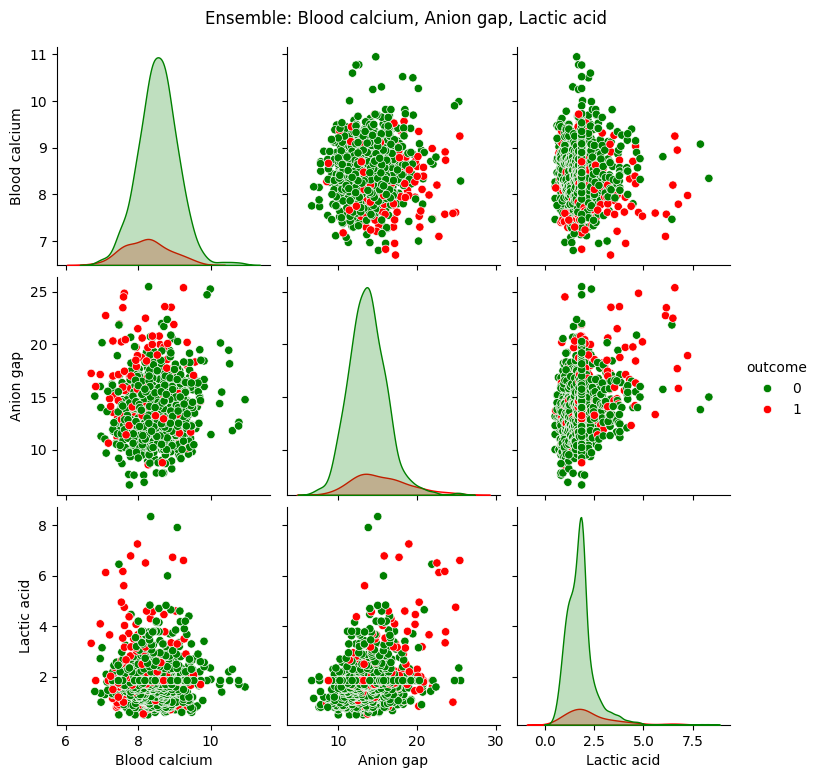

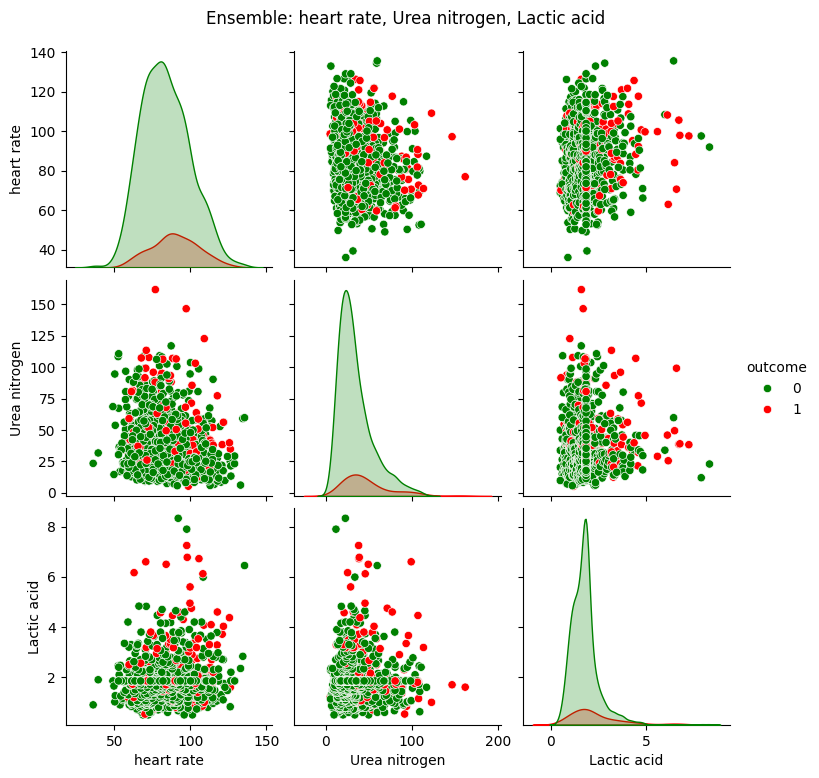

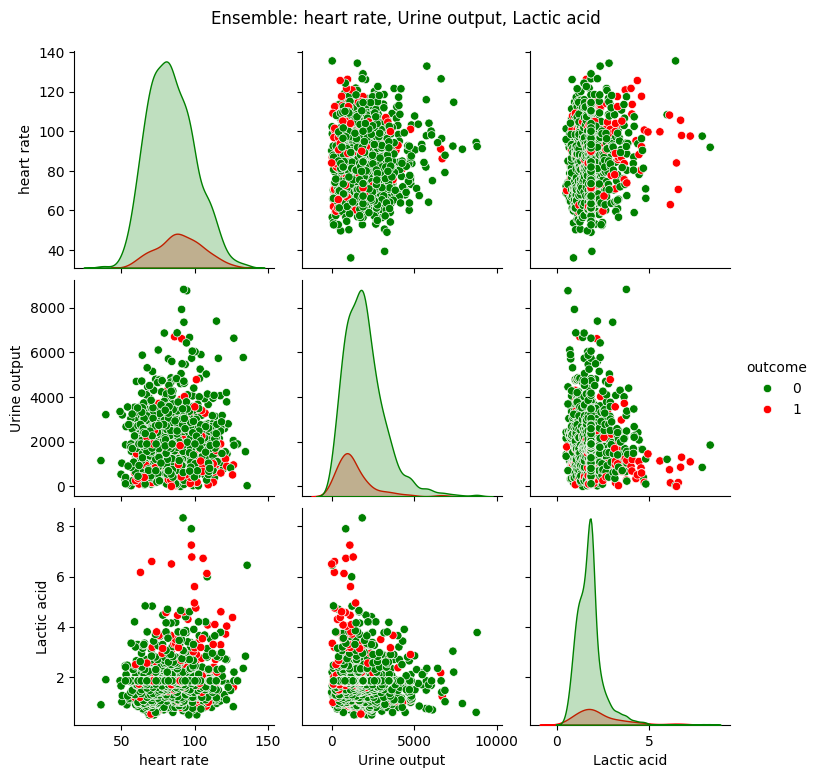

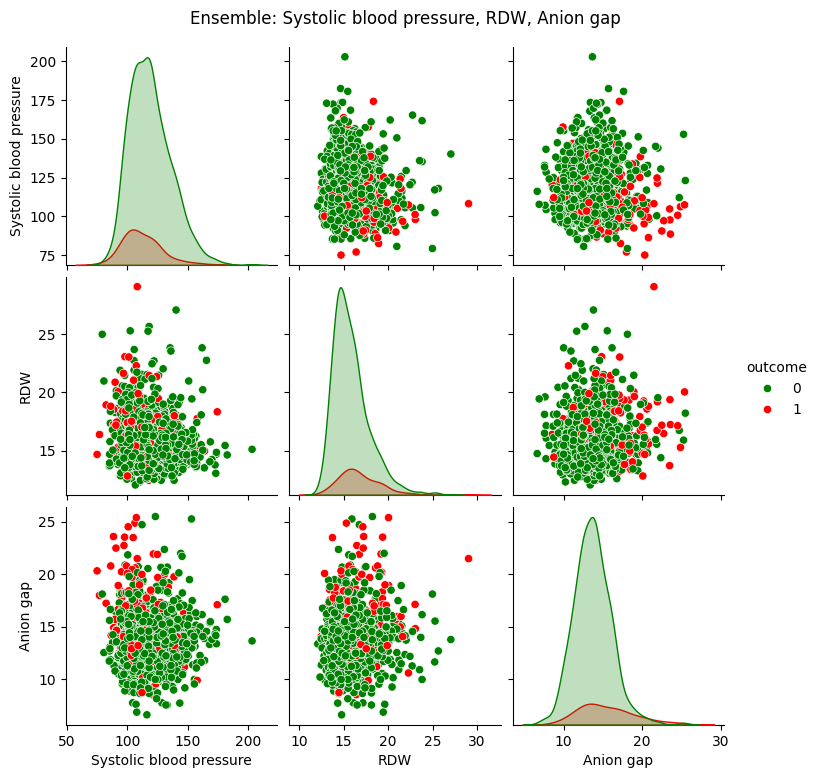

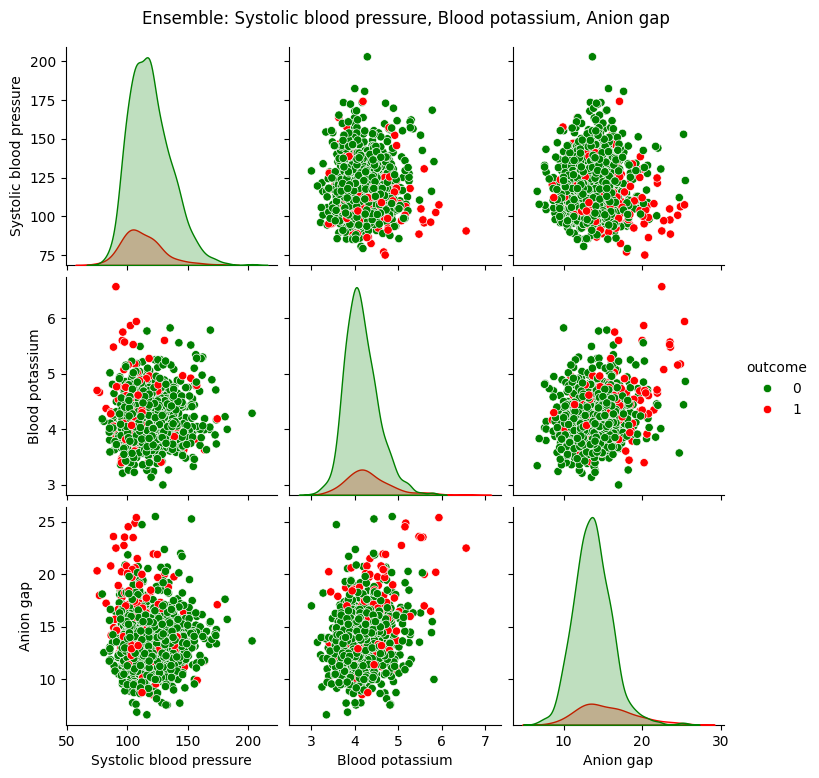

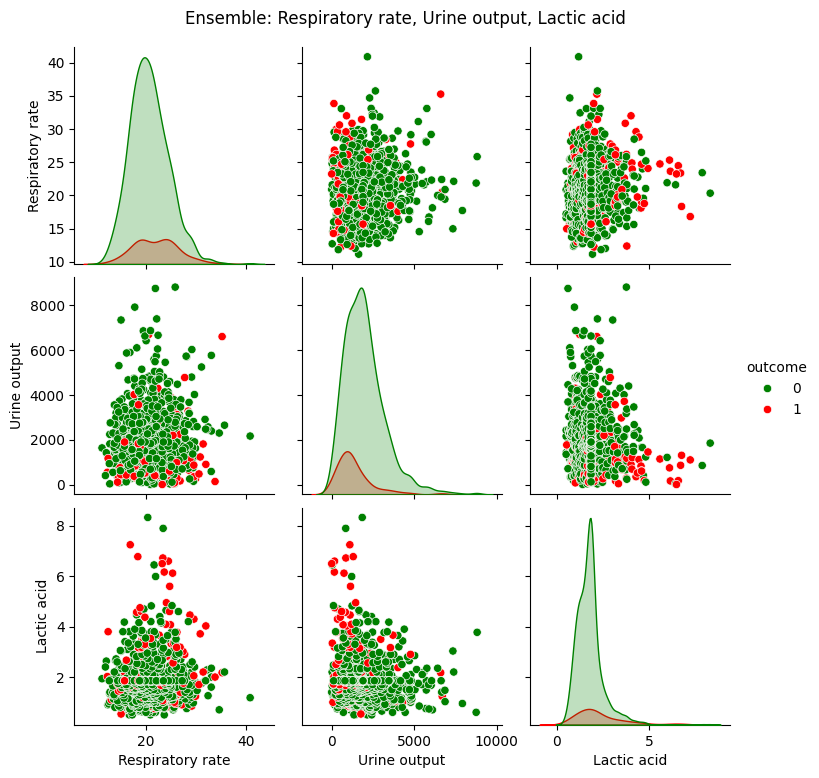

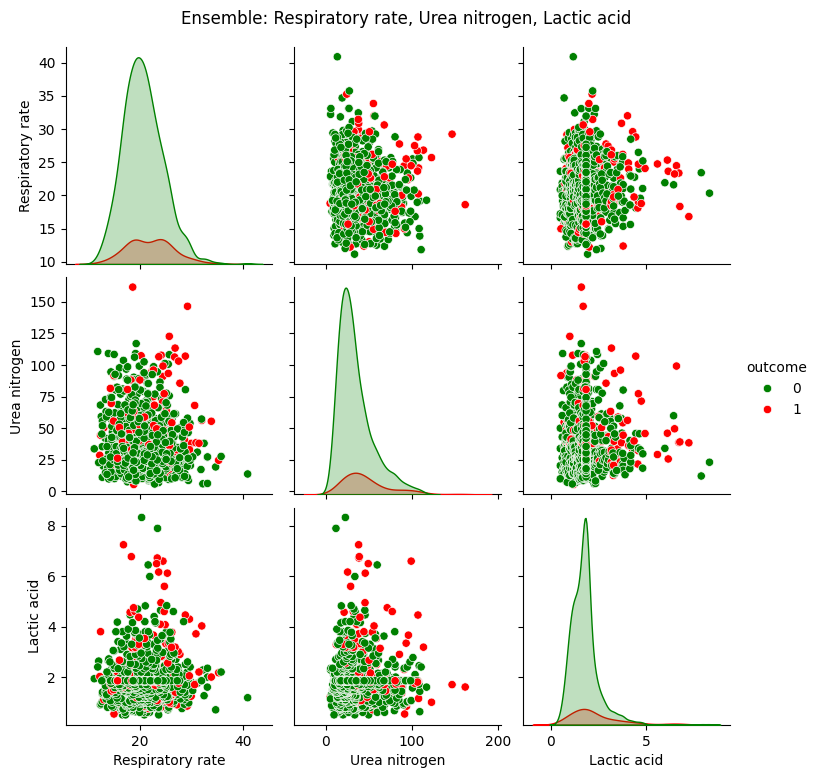

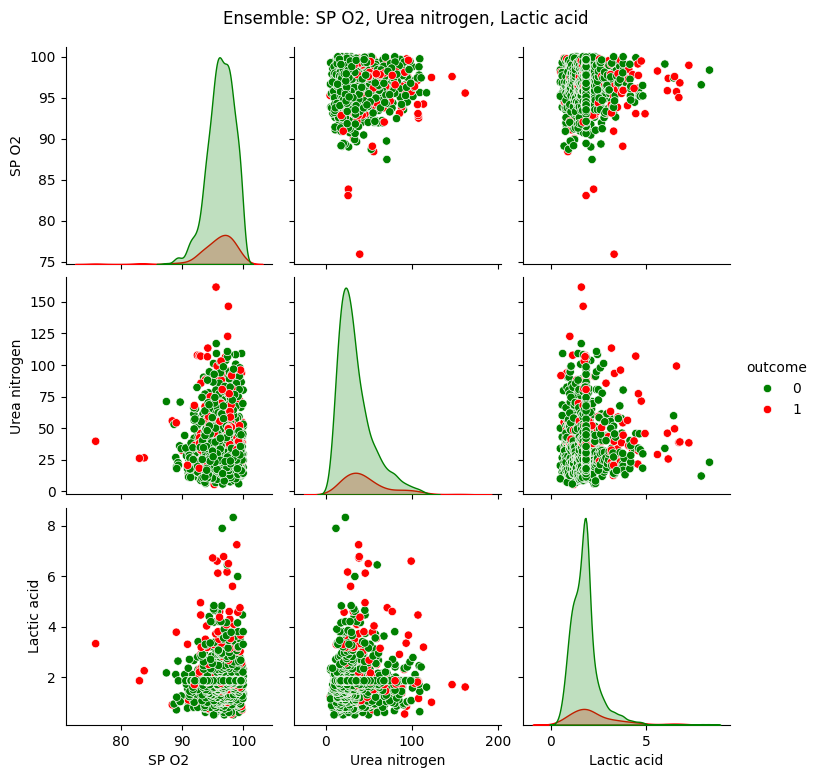

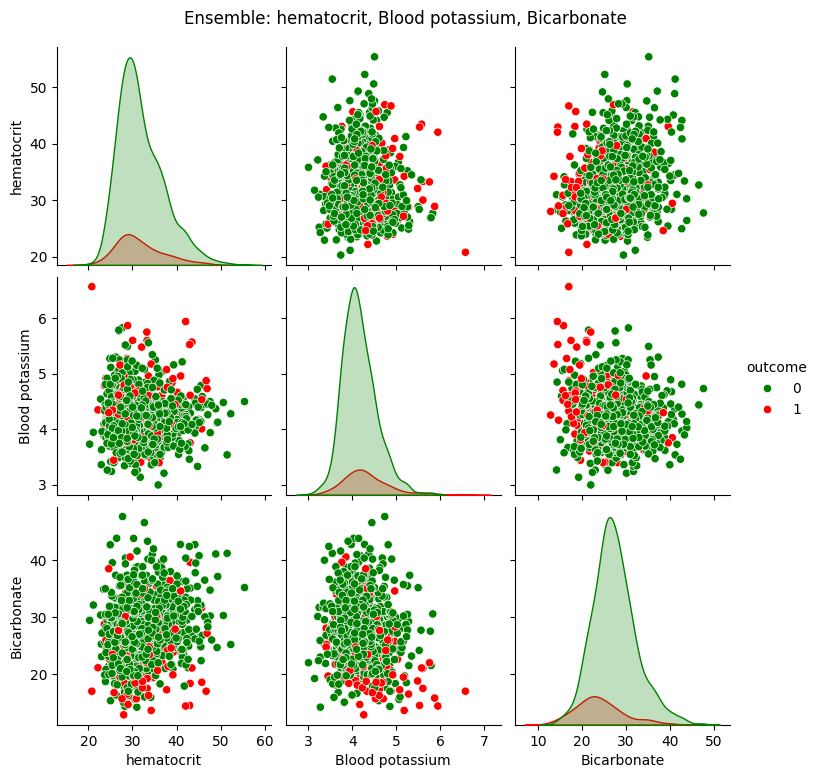

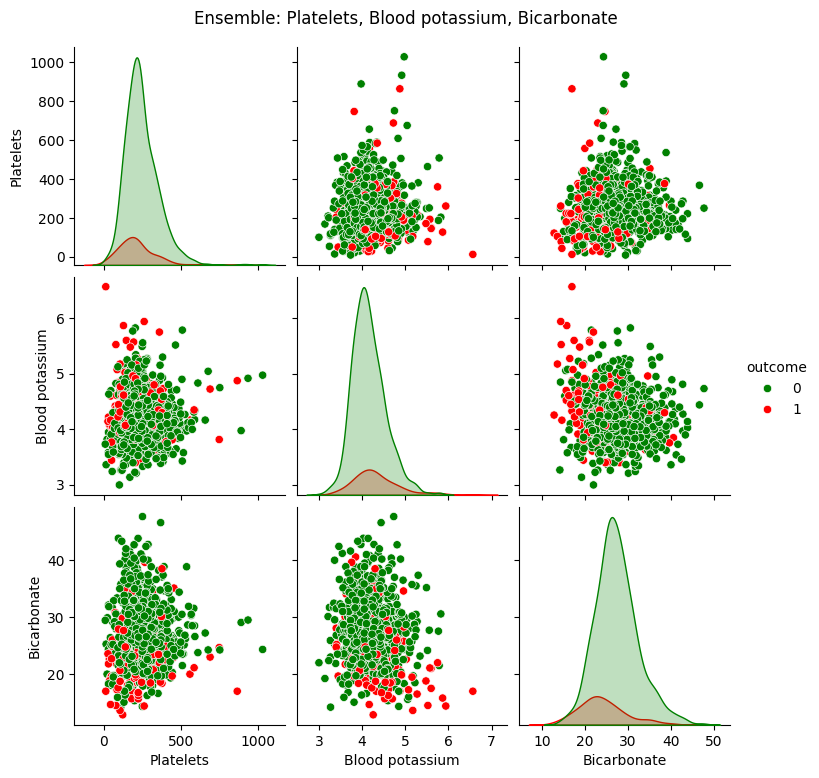

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
          
# Make pairplots for each of the top 10 ensembles for exploratory data analysis
for ensemble in top10LR:
    subset_df = df1[list(ensemble) + ["outcome"]]  # Select columns of ensemble and "outcome"
    pairplot = sns.pairplot(subset_df, hue="outcome", palette={"0": "green", "1": "red"}.values())
    pairplot.fig.suptitle('Ensemble: ' + ', '.join(ensemble), y=1.03)
    plt.show()

In [6]:
top10indicesLR = []
top50indicesLR = []

for ensemble in top50LR:
    index = list(accuraciesLR.keys()).index(ensemble)
    if len(top10indicesLR) < 10:
        top10indicesLR.append(index)
    top50indicesLR.append(index)

print("Model Coefficients for the top 10 ensembles")
for index in top10indicesLR:
    model = modelsLR[index]
    ensemble = allEnsembles[index]
    coefficients = model.coef_
    print("\nColumns:", ensemble, "\nCoefficients:", coefficients)

Model Coefficients for the top 10 ensembles

Columns: ('Blood calcium', 'Anion gap', 'Lactic acid') 
Coefficients: [[-1.03252433  0.21422091 -0.00405508]]

Columns: ('heart rate', 'Urea nitrogen', 'Lactic acid') 
Coefficients: [[ 0.03091895  0.02504876 -0.06982544]]

Columns: ('heart rate', 'Urine output', 'Lactic acid') 
Coefficients: [[ 0.02371812 -0.00047218 -0.08191985]]

Columns: ('Systolic blood pressure', 'RDW', 'Anion gap') 
Coefficients: [[-0.01542157  0.17020151  0.02361099]]

Columns: ('Systolic blood pressure', 'Blood potassium', 'Anion gap') 
Coefficients: [[-0.01884787  1.21328944  0.03758682]]

Columns: ('Respiratory rate', 'Urine output', 'Lactic acid') 
Coefficients: [[ 0.08800663 -0.00049753 -0.08100689]]

Columns: ('Respiratory rate', 'Urea nitrogen', 'Lactic acid') 
Coefficients: [[ 0.08404689  0.02114094 -0.07632598]]

Columns: ('SP O2', 'Urea nitrogen', 'Lactic acid') 
Coefficients: [[-0.18260112  0.02034342 -0.09224466]]

Columns: ('hematocrit', 'Blood potassium'

Naive Bayesian

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def NB(df, cols, target='outcome'):
    X = df[list(cols)]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cmNB = confusion_matrix(y_test, y_pred)
    return accuracy, cmNB

accuracy0NB, cmNB0 = NB(df0, df0.columns.tolist())

# Calculate accuracy for each combination
accuraciesNB = {}
for ensemble in allEnsembles:
    accuracy, cm = NB(df1, ensemble)
    accuraciesNB[ensemble] = accuracy

Naive Bayesian accuracy using all columns: 0.8828522920203735 



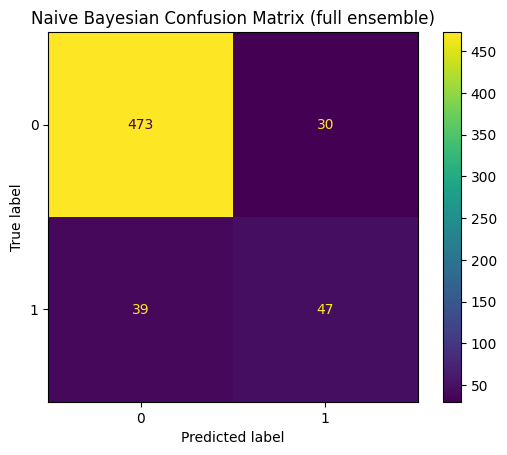

TPR: 0.5465116279069767 
TNR: 0.9403578528827038

Number of ensembles that perform better than the base model: 0

Top 10 Most Accurate Ensembles:

Columns: Diastolic blood pressure, Creatinine, Anion gap ; Accuracy: 0.8709677419354839

Columns: Platelets, Anion gap, Bicarbonate ; Accuracy: 0.8709677419354839

Columns: Creatinine, Anion gap, Bicarbonate ; Accuracy: 0.8709677419354839

Columns: Respiratory rate, Urine output, Anion gap ; Accuracy: 0.8692699490662139

Columns: Urine output, Creatinine, Anion gap ; Accuracy: 0.8692699490662139

Columns: Urine output, Anion gap, Bicarbonate ; Accuracy: 0.8692699490662139

Columns: hematocrit, Anion gap, PH ; Accuracy: 0.8692699490662139

Columns: MCH, Blood calcium, Anion gap ; Accuracy: 0.8692699490662139

Columns: Lymphocyte, Anion gap, PH ; Accuracy: 0.8692699490662139

Columns: Creatinine, Blood calcium, Anion gap ; Accuracy: 0.8692699490662139


In [22]:
# Find which ensembles perform better than the base model
betterEnsemblesNB = []
for index, ensemble in enumerate(allEnsembles):
    accuracy = accuraciesNB[ensemble]
    if accuracy > accuracy0NB:
        betterEnsemblesNB.append(ensemble)

top10NB = sorted(accuraciesNB, key=accuraciesNB.get, reverse=True)[:10]
top50NB = sorted(accuraciesNB, key=accuraciesNB.get, reverse=True)[:50]

def TPRandTNR(confusion):
    TN, FP, FN, TP = confusion.ravel()
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    return TPR, TNR

print('Naive Bayesian accuracy using all columns:', accuracy0NB, '\n')

cmNB0Disp = ConfusionMatrixDisplay(cmNB0)
cmNB0Disp.plot()
plt.title('Naive Bayesian Confusion Matrix (full ensemble)')
plt.show()

print('TPR:', TPRandTNR(cmNB0)[0], '\nTNR:', TPRandTNR(cmNB0)[1])
print('\nNumber of ensembles that perform better than the base model:', len(betterEnsemblesNB))

print("\nTop 10 Most Accurate Ensembles:")
for ensemble in top10NB:
    accuracy = accuraciesNB[ensemble]
    print("\nColumns:", ", ".join(ensemble), "; Accuracy:", accuracy)

In [11]:
# Calculate collinearities for top 50 combinations
collinearitiesOfTopNB = []
for ensemble in top50NB:
    collinearity = calculateCollinearity(df1, ensemble)
    collinearitiesOfTopNB.append(collinearity)

selectCollsNB = pd.Series(collinearitiesOfTopNB)

print("Summary of collinearities of top 50 ensembles:")
print(selectCollsNB.describe())

Summary of collinearities of top 50 ensembles:
count    50.000000
mean      0.480160
std       0.326222
min       0.039941
25%       0.189673
50%       0.386030
75%       0.711381
max       1.402716
dtype: float64


Random Forest

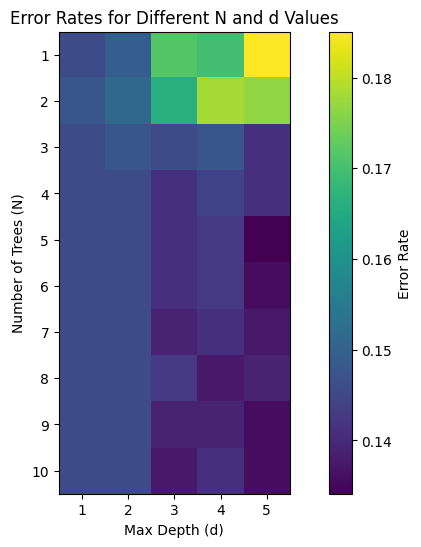

Best combination of N and d: N=5, d=5, with error rate=0.1341


In [20]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

X = df0.drop(['outcome'], axis=1)
y = df0['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

error_rates = []
best_error_rate = float('inf')
bestN = None
bestd = None

# Loop through different values of N and d
for N in range(1, 11):
    for d in range(1, 6):
        # Train Random Forest Classifier
        rf_classifier = RandomForestClassifier(n_estimators=N, max_depth=d, random_state=123)
        rf_classifier.fit(X_train, y_train)
        y_pred = rf_classifier.predict(X_test)
        
        # Calculate error rate
        error_rate = 1 - accuracy_score(y_test, y_pred)
        error_rates.append((N, d, error_rate))
        
        # Check if this combination has the lowest error rate
        if error_rate < best_error_rate:
            best_error_rate = error_rate
            bestN = N
            bestd = d
            
# Plot error rates
errors_df = pd.DataFrame(error_rates, columns=['N', 'd', 'Error Rate'])
errors_df_pivot = errors_df.pivot(index='N', columns='d', values='Error Rate')
plt.figure(figsize=(10, 6))
plt.imshow(errors_df_pivot, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Error Rate')
plt.xlabel('Max Depth (d)')
plt.ylabel('Number of Trees (N)')
plt.title('Error Rates for Different N and d Values')
plt.xticks(ticks=range(5), labels=range(1, 6))
plt.yticks(ticks=range(10), labels=range(1, 11))
plt.show()

print(f"Best combination of N and d: N={bestN}, d={bestd}, with error rate={best_error_rate:.4f}")

In [13]:
def RF(df, cols, target='outcome'):
    X = df[list(cols)]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)
    model = RandomForestClassifier(n_estimators=bestN, max_depth=bestd, random_state=123)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cmRF = confusion_matrix(y_test, y_pred)
    return accuracy, cmRF

accuracy0RF, cmRF0 = RF(df0, df0.columns.tolist())

# Calculate accuracy for each combination
accuraciesRF = {}
for ensemble in allEnsembles:
    accuracy, cm = RF(df1, ensemble)
    accuraciesRF[ensemble] = accuracy

Random Forest accuracy using all columns: 0.9490662139219015 



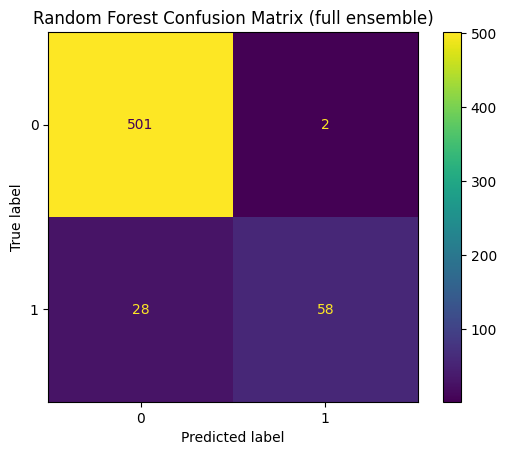

TPR: 0.6744186046511628 
TNR: 0.9960238568588469

Number of ensembles that perform better than the base model: 0

Top 10 Most Accurate Ensembles:

Columns: Creatinine, Bicarbonate, Lactic acid ; Accuracy: 0.8743633276740238

Columns: Leucocyte, Bicarbonate, Lactic acid ; Accuracy: 0.8726655348047538

Columns: Lymphocyte, Bicarbonate, Lactic acid ; Accuracy: 0.8726655348047538

Columns: Anion gap, Bicarbonate, Lactic acid ; Accuracy: 0.8726655348047538

Columns: Urea nitrogen, Bicarbonate, Lactic acid ; Accuracy: 0.8709677419354839

Columns: age, Bicarbonate, Lactic acid ; Accuracy: 0.8692699490662139

Columns: heart rate, Bicarbonate, Lactic acid ; Accuracy: 0.8692699490662139

Columns: Diastolic blood pressure, Blood potassium, Anion gap ; Accuracy: 0.8692699490662139

Columns: SP O2, Anion gap, Bicarbonate ; Accuracy: 0.8692699490662139

Columns: Urine output, Bicarbonate, Lactic acid ; Accuracy: 0.8692699490662139


In [23]:
# Find which ensembles perform better than the base model
betterEnsemblesRF = []
for index, ensemble in enumerate(allEnsembles):
    accuracy = accuraciesRF[ensemble]
    if accuracy > accuracy0RF:
        betterEnsemblesRF.append(ensemble)

top10RF = sorted(accuraciesRF, key=accuraciesRF.get, reverse=True)[:10]
top50RF = sorted(accuraciesRF, key=accuraciesRF.get, reverse=True)[:50]

print('Random Forest accuracy using all columns:', accuracy0RF, '\n')

cmRF0Disp = ConfusionMatrixDisplay(cmRF0)
cmRF0Disp.plot()
plt.title('Random Forest Confusion Matrix (full ensemble)')
plt.show()

print('TPR:', TPRandTNR(cmRF0)[0], '\nTNR:', TPRandTNR(cmRF0)[1])
print('\nNumber of ensembles that perform better than the base model:', len(betterEnsemblesRF))

print("\nTop 10 Most Accurate Ensembles:")
for ensemble in top10RF:
    accuracy = accuraciesRF[ensemble]
    print("\nColumns:", ", ".join(ensemble), "; Accuracy:", accuracy)